In [1]:
import bs4
import matplotlib.pyplot as plt
import wordcloud 
import requests
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
import io

In [2]:
url = 'https://en.wikipedia.org/wiki/Elon_Musk'

#download html
req = requests.get(url)
req.raise_for_status()

In [3]:
#create soup object and use CSS selectors to get paragraph elements
Soup = bs4.BeautifulSoup(req.text)
text_elem = Soup.select('p')

In [4]:
#iterate through text element and combine paragraphs
full_text = []
for par in text_elem: 
    full_text.append(par.getText().replace('\n', '').replace('\xa0', ' '))
full_text = ''.join(full_text)

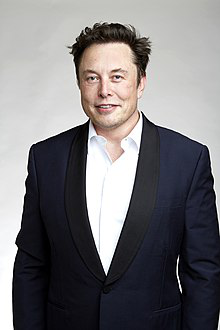

In [5]:
#get image
im_elem = Soup.select('img[decoding="async"]')

#select the first image of decent size to ensure its not a logo or thumbnail
for elem in im_elem:
    im_url = 'https:' + elem.get('src')
    im_req = requests.get(im_url)
    im_req.raise_for_status()
    im = im_req.content
    im = Image.open(io.BytesIO(im))
    if im.width > 50:
        break
im

In [6]:
####################################
#create mask with image segmentation
####################################

#load pretrained model
net = torch.hub.load('pytorch/vision', 'deeplabv3_resnet101', pretrained = True)
net.eval()

Using cache found in C:\Users\15055/.cache\torch\hub\pytorch_vision_master


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

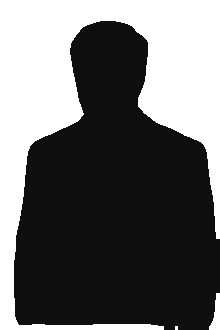

In [7]:
#reshape image and apply necessary transformations
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#apply transform and create mini batch
img = transforms(im).unsqueeze(0)

#use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
img = img.to(device)
net = net.to(device)

with torch.no_grad():
    prediction = net(img)['out'][0]
    
mask = prediction.argmax(0).cpu().numpy()
mask = np.where(mask==15, mask, 255)
Image.fromarray(mask.astype(np.uint8))

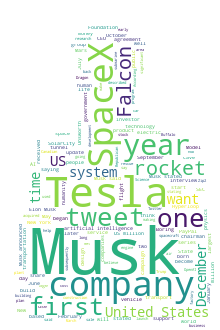

In [8]:
#####################################################
#Create wordcloud using text and in the shape of mask
#####################################################
wikiCloud = wordcloud.WordCloud(background_color="white", mask=mask).generate(full_text)
wikiCloud = np.asarray(wikiCloud)
Image.fromarray(wikiCloud)